In [1]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import time
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import spacy
from anchor import anchor_text
import pickle
from myUtils import *
import transformerUtils.models as models
import transformerUtils.training as training
import transformerUtils.plot as plot
from transformerUtils.utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
review_parser = None
label_parser = None
ds_train = None
ds_valid = None
ds_test = None

review_parser, label_parser, ds_train, ds_valid, ds_test = create_sentiment_dataset()
counter_test, counter_test_labels = counter_test()

Number of tokens in training samples: 3307
Number of tokens in training labels: 2


In [4]:
model = load_model('gru' , 'transformerUtils/gru_sentiment.pt', review_parser)

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.7, 'lr': 0.0005, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(3307, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.7)
  (dropout_layer): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [5]:
# 1 = pad 2=sos 3 = eof 
def tokenize(text, max_len):
    sentence = review_parser.tokenize(str(text))
    input_tokens = [2] + [review_parser.vocab.stoi[word] for word in sentence] + [3] + [1]*(max_len-len(sentence))

    return input_tokens

In [6]:
def predict_sentences(sentences):
    half_length = len(sentences)//2
    if(half_length>800):
        return np.concatenate([predict_sentences(sentences[:half_length]), predict_sentences(sentences[half_length:])])
    max_len = max([len(sentence) for sentence in sentences])
    sentences = torch.tensor([tokenize(sentence, max_len) for sentence in sentences]).to(device)
    input_tokens = torch.transpose(sentences, 0, 1)
    output = model(input_tokens)
    return torch.argmax(output, dim=1).cpu().numpy()

In [7]:
nlp = spacy.load('en_core_web_sm')

In [24]:
explainer = anchor_text.AnchorText(nlp, ['positive', 'negative'], use_unk_distribution=False)

In [9]:
test = pickle.load( open( "results/transformer_test.pickle", "rb" ))
test_labels = pickle.load( open( "results/transformer_test_labels.pickle", "rb" ))
test = np.array(test)
test_labels = np.array(test_labels)
exps= []
#xps_file  = open( "results/transformer_exps.pickle", "rb" )
exps  = pickle.load(open( "results/transformer_exps_list.pickle", "rb" ))

In [10]:
exps = [ExtendedExplanation(exp, test, test_labels, predict_sentences, explainer) for exp in exps]

In [10]:
exps = pickle.load(open( "results/transformer_extended_exps.pickle", "rb" ))

In [11]:
explanations = [exp for exp in exps if len(exp.fit_examples) > 7] 
explanations.sort(key=lambda exp: exp.test_precision)

In [49]:
anchor_examples = pickle.load(open( "results/transformer_anchor_examples.pickle", "rb" ))

In [59]:
filtered = [exp for exp in explanations if len(' '.join(exp.names))>3]
best = filtered[-10:]
best.reverse()
for exp in best:
    print("------------------------")
    print(str(anchor_examples[exp.index]))
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    print('Prediction:', explainer.class_names[exp_label])
    print('Anchor: %s' % (' AND '.join(exp.names)))
    print('Precision: %.2f' % exp.precision)
    print('Coverage: %.2f' % exp.coverage)
    print('Anchor test precision: %.2f' % exp.test_precision)
    print('Anchor test coverage: %.2f' % (exp.test_cov))
    covered_labels = counter_test_labels[exp.fit_examples]
    ##### the trained model has the opposite label
    real_percentage = 1- np.mean(covered_labels == exp_label)
    print('Anchor test REAL precision: %.2f' % real_percentage)
   

------------------------
murder and mayhem of this sort quickly becomes monotonous .
Prediction: negative
Anchor: becomes
Precision: 0.97
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.03
Anchor test REAL precision: 0.50
------------------------
a mild , reluctant , thumbs down .
Prediction: negative
Anchor: mild
Precision: 0.99
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.64
------------------------
a very depressing movie of many missed opportunities .
Prediction: negative
Anchor: missed
Precision: 0.99
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.64
------------------------
nasty , ugly , pointless and depressing , even if you hate clowns .
Prediction: negative
Anchor: pointless
Precision: 1.00
Coverage: 0.00
Anchor test precision: 1.00
Anchor test coverage: 0.01
Anchor test REAL precision: 0.73
------------------------
the whole thing plays like a tired 

In [60]:
red = "\033[1;30;41m"
blue = "\033[1;30;44m"
purple = "\033[1;30;45m"
colors = {'positive': blue, "negative": red}

In [61]:
anchor_sentences = {}

In [62]:
best = best[:5]

In [63]:
for exp in best:
    exp_label =  predict_sentences([str(anchor_examples[exp.index])])[0]
    same_label_examples = [index for index in exp.fit_examples if counter_test_labels[index] == exp_label]
    anchor_name = ' AND '.join(exp.names)
    anchor_sentences[anchor_name+'-'+explainer.class_names[exp_label]] = counter_test[same_label_examples]

In [54]:
def calc_predictions(sentences):
    predictions = predict_sentences(sentences)
    labels = [explainer.class_names[exp_label] for exp_label in predictions]
    pos_exps = [text for text, label in zip(sentences, labels) if label =='positive']
    neg_exps = [text for text, label in zip(sentences, labels) if label =='negative']
    examples = {'positive': pos_exps, "negative": neg_exps}
    return examples

In [55]:
def print_predictions(sentences):
    examples = calc_predictions(sentences)
    for exp_type in examples.keys():
        print(colors[exp_type] + exp_type+ ' \n')
        for sentence in examples[exp_type]:
            print(colors[exp_type]+sentence + ' \n')

In [ ]:
for anchor in anchor_sentences.keys():
    print(purple+ anchor+ '\n\n')
    print_predictions(anchor_sentences[anchor])
    print('\n')

In [64]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='bert-large-uncased')

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [65]:
unmasker("Their [MASK] are far greater than anything we ever imagined, amazing !", top_k=10)

[{'sequence': 'their powers are far greater than anything we ever imagined, amazing!',
  'score': 0.8306710720062256,
  'token': 4204,
  'token_str': 'powers'},
 {'sequence': 'their abilities are far greater than anything we ever imagined, amazing!',
  'score': 0.07756263762712479,
  'token': 7590,
  'token_str': 'abilities'},
 {'sequence': 'their forces are far greater than anything we ever imagined, amazing!',
  'score': 0.0097120376303792,
  'token': 2749,
  'token_str': 'forces'},
 {'sequence': 'their numbers are far greater than anything we ever imagined, amazing!',
  'score': 0.009242216125130653,
  'token': 3616,
  'token_str': 'numbers'},
 {'sequence': 'their capabilities are far greater than anything we ever imagined, amazing!',
  'score': 0.00755634531378746,
  'token': 9859,
  'token_str': 'capabilities'},
 {'sequence': 'their wonders are far greater than anything we ever imagined, amazing!',
  'score': 0.0042161643505096436,
  'token': 16278,
  'token_str': 'wonders'},
 {'s

In [66]:
def predict_similar(word, prediction, sentence, print_generated=False):
    sentence = sentence.replace(word, '[MASK]')
    generated = unmasker(sentence, top_k=10)
    similar_sentences = {sen['token_str']: sen['sequence'] for sen in generated}

    negatives = {}
    positives = {}
    for cur_word, sen in similar_sentences.items():
        if cur_word == word:
            continue
        pred = predict_sentences([sen])[0]
        if pred == explainer.class_names.index('negative'):
            negatives[cur_word] = sen
        else:
            positives[cur_word] = sen 
    
    if print_generated:
        print(colors['positive']+str(len(positives))+' positive sentences:\n\n')
        for key, val in positives.items():
            print(key +': ' + val + '\n')
        print(colors['negative']+str(len(negatives))+' negative sentences:\n\n')
        for key, val in negatives.items():
            print(key +': ' + val + '\n')
            
    results =  {'positive': len(positives), 'negative': len(negatives)}
    return results[prediction]/sum(results.values())

In [68]:
anchor_sentences.keys()

dict_keys(['becomes-negative', 'mild-negative', 'missed-negative', 'pointless-negative', 'tired-negative'])

In [ ]:
predict_similar('pointless', 'negative',anchor_sentences['pointless-negative'][0], True)

In [74]:
def anchors_percent(anchor_sentences):
   
    for anchor in anchor_sentences.keys():
        anchor_name, anchor_prediction = anchor.split('-')
        examples = calc_predictions(anchor_sentences[anchor])
        percents = {}
       
        for example in examples[anchor_prediction]:
            if example.count(anchor_name)>1:
                continue
            percent = predict_similar(anchor_name, anchor_prediction, example)
            percents[example] = percent
    
        fig = plt.figure(figsize = (3,3))
        ax = fig.add_axes([0,0,1,1])
        keys = [value[:50] for value in percents.keys()]
        ax.bar(keys, percents.values())
        plt.title(anchor)
        plt.xticks(rotation=40, ha='right', fontsize = '13')
        plt.ylim([0,1])
        plt.ylabel('same class percent')
        plt.show()

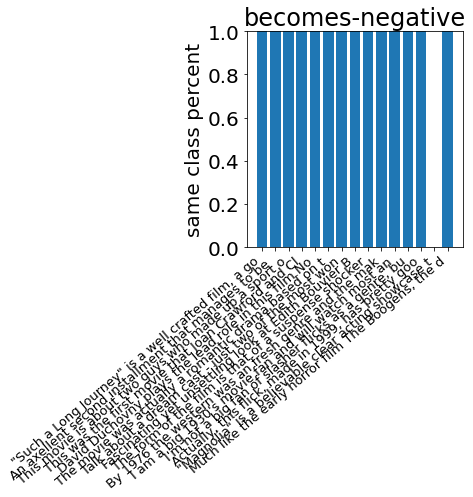

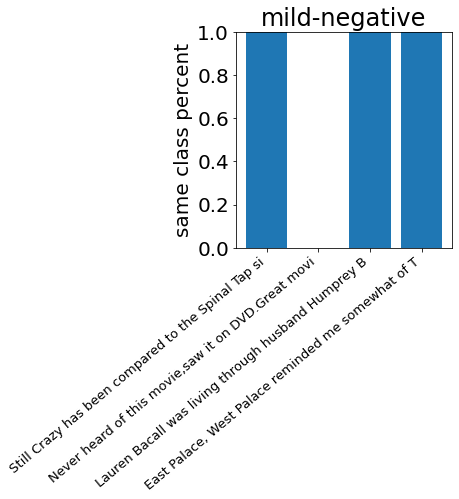

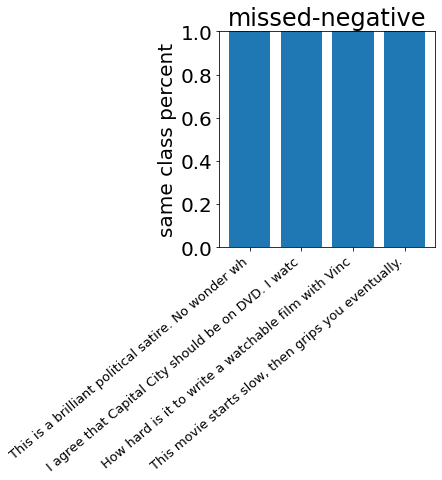

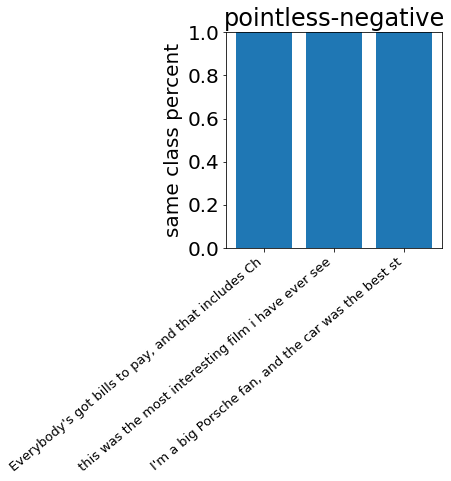

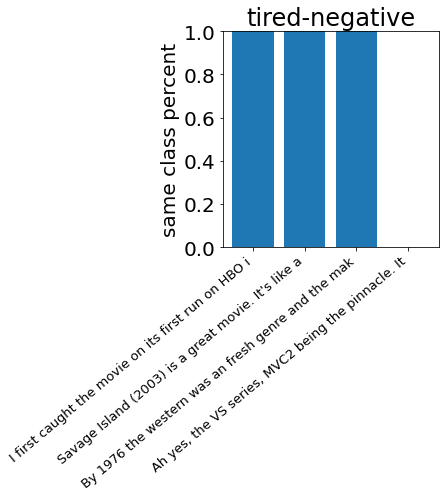

In [75]:
anchors_percent(anchor_sentences)